### User role:
you who is chatting or who's asking chat gpt

### assistant role: 
They are the model’s responses based on the user messages.
Can serve theoritically in simulated few shot prompt engineering

### System role: 
Allows you to specify the way the model answers questions

In [6]:
from openai import OpenAI
import pandas as pd


client = OpenAI()
df = pd.read_csv('verbs.csv')

def translate_verb(verb):
    completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages = [        
            {"role": "system", "content": "You are an expert in Moroccan Darija dialect and in translating Darija to English." +           
             "Translate the provided Moroccan Darija language verbs into English using word-by-word translation." + 
             "Please fulfill the following conditions when translating:"+
             "The output must not be an infinitive verb. No explanations are needed in the output"+
             "Purpose of the translation: To study the accuracy of LLMs on Low resource languages, particularly Darija." + 
             "Target audience: Computational linguists"
             },            
            {"role": "user", "content": "شرب"},

            {"role": "assistant", "content": "drink"},

            {"role": "user", "content":  f'{verb}' }
        ],
        temperature=0.1  # Deterministic responses
    )
    return completion.choices[0].message.content

# Apply the translation function to the 'darija_ar' column
df['english_translation'] = df['darija_ar'].apply(translate_verb)

print(df)


           n1       n2     n3       n4       n5    n6 darija_ar         eng  \
0         kla      NaN    NaN      NaN      NaN   NaN       كلا         eat   
1        chrb    chreb    NaN      NaN      NaN   NaN       شرب       drink   
2       dkhel     dkhl  dkhal     d5el      d5l  d5al       دخل       enter   
3        khrj    khraj  khrej      5rj     5raj  5rej       خرج      go out   
4        fhem      fhm   fham     f8em      f8m  f8am       فهم  understand   
...       ...      ...    ...      ...      ...   ...       ...         ...   
1027   bllegh      NaN    NaN      NaN      NaN   NaN      بلّغ      notify   
1028      Tfa      NaN    NaN      NaN      NaN   NaN       طفا    turn off   
1029    ryye7    riye7   ryy7      NaN      NaN   NaN      ريّح    sit down   
1030    ghech  ghechch   ghch    ghach      NaN   NaN        غش       cheat   
1031  9chcher    9cher  qcher  qchcher  9chchar   NaN      قشّر        peel   

     english_translation  
0                    eat

In [7]:
from nltk.corpus import wordnet as wn

dataset = df.copy()

columns_to_delete = ['n2', 'n3', 'n4', 'n5', 'n6']
dataset.drop(columns=columns_to_delete, inplace=True)

eng = dataset['eng']
transl = dataset['english_translation']
transl = [verb.replace(" ", "_") for verb in transl]
eng = [verb.replace(" ", "_") for verb in eng]

def max_path_similarity(word1, word2):
    """Calculate the maximum path similarity between two words."""

    synsets1 = wn.synsets(word1, pos=wn.VERB)
    synsets2 = wn.synsets(word2, pos=wn.VERB)
    max_score = 0
    for syn1 in synsets1:
        for syn2 in synsets2:
            score = syn1.path_similarity(syn2)
            if score and score > max_score:
                max_score = score
    return max_score

def evaluate_pairs(threshold=0.5):
    """Evaluating each pair using WordNet path similarity and a threshold."""
    results = []
    for i in range(len(transl)):
        word1, word2 = transl[i], eng[i]
        similarity = max_path_similarity(word1, word2)
        results.append((word1, word2, similarity, similarity >= threshold))
    return results
results = evaluate_pairs()
similarities = [item[2] for item in results]

dataset['similarity'] = similarities
mean_similarity = dataset['similarity'].mean()


print(f'Mean value of similarities is: {mean_similarity}')
dataset.describe()



Mean value of similarities is: 0.5748103721214186


,similarity
count,1032.000000
mean,0.574810
std,0.384249
min,0.000000
25%,0.250000
50%,0.500000
75%,1.000000
max,1.000000


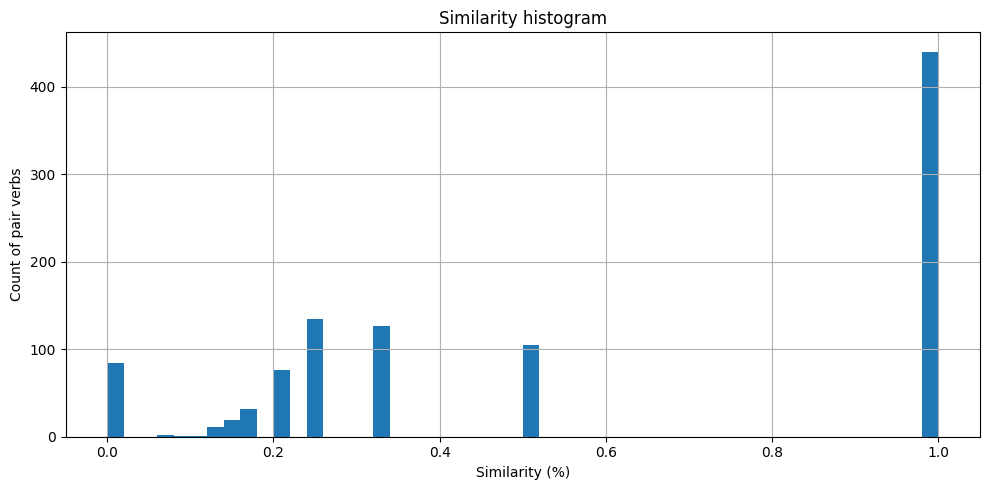

In [8]:
import matplotlib.pyplot as plt

dataset.hist(bins=50, figsize=(10,5))
plt.xlabel('Similarity (%)')
plt.ylabel('Count of pair verbs')
plt.title('Similarity histogram')
plt.tight_layout()
plt.grid(True)
plt.show()


In [9]:
zero_df = dataset[dataset['similarity'] == 0]
print(zero_df)


           n1 darija_ar      eng english_translation  similarity
27      tsalm     تسالم   salute         you be safe         0.0
51       khss       خسّ   should                 cut         0.0
54       khbr       خبر     tell                news         0.0
76      ftarD     فتارض  suppose     you will accept         0.0
87       sifT      سيفط     send           will open         0.0
...       ...       ...      ...                 ...         ...
954   stelzem     ستلزم   entail           will need         0.0
955     nffed      نفّد  execute          we run out         0.0
978    stfser     ستفسر  inquire            will ask         0.0
1013   nkharT     نخارط   adhere            we write         0.0
1015   sted3a     ستدعا   summon           will call         0.0

[84 rows x 5 columns]
